# Importing the required Packages

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Moving the data to a separate Directory and Making it in Tensorflow readable format

In [2]:
train_csv_path='/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/RFMiD_Training_Labels.csv'
train_ds_csv=pd.read_csv(train_csv_path)

In [3]:
train_ds_csv.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


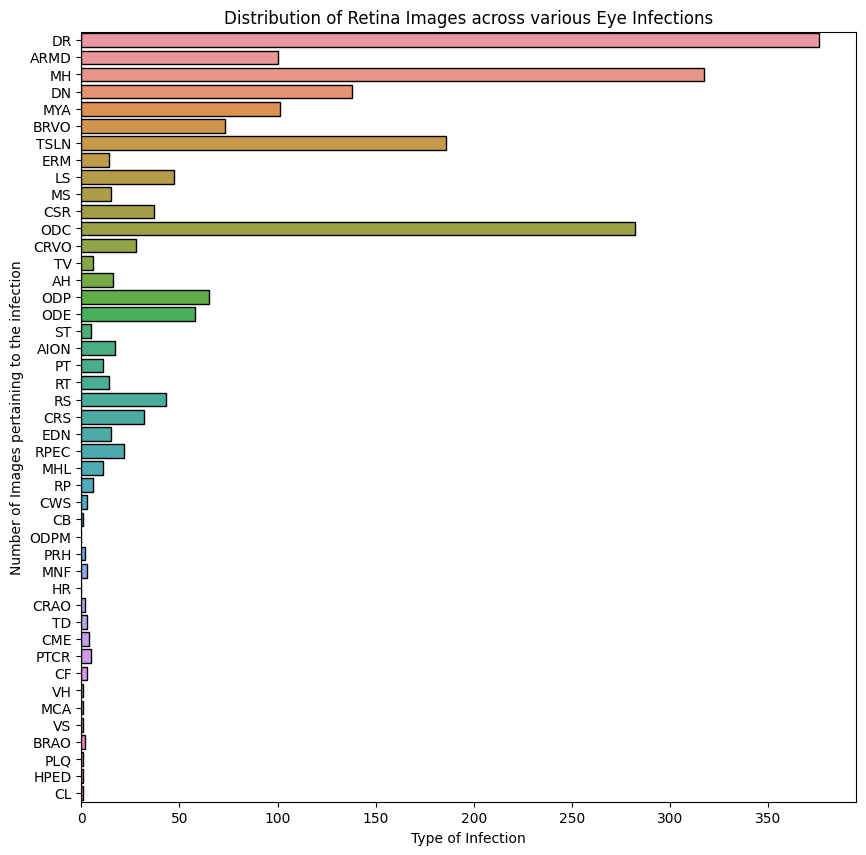

In [4]:
infected_retinas = dict(train_ds_csv.drop(["ID", "Disease_Risk"], axis=1).sum())
retina_infections = list(infected_retinas.keys())
infection_freq = list(infected_retinas.values())
plt.figure(figsize = (10,10))
sns.barplot(y = retina_infections,
            x = infection_freq,
            edgecolor = "black",
            orient = "h")
plt.title("Distribution of Retina Images across various Eye Infections")
plt.xlabel("Type of Infection")
plt.ylabel("Number of Images pertaining to the infection")
plt.show()

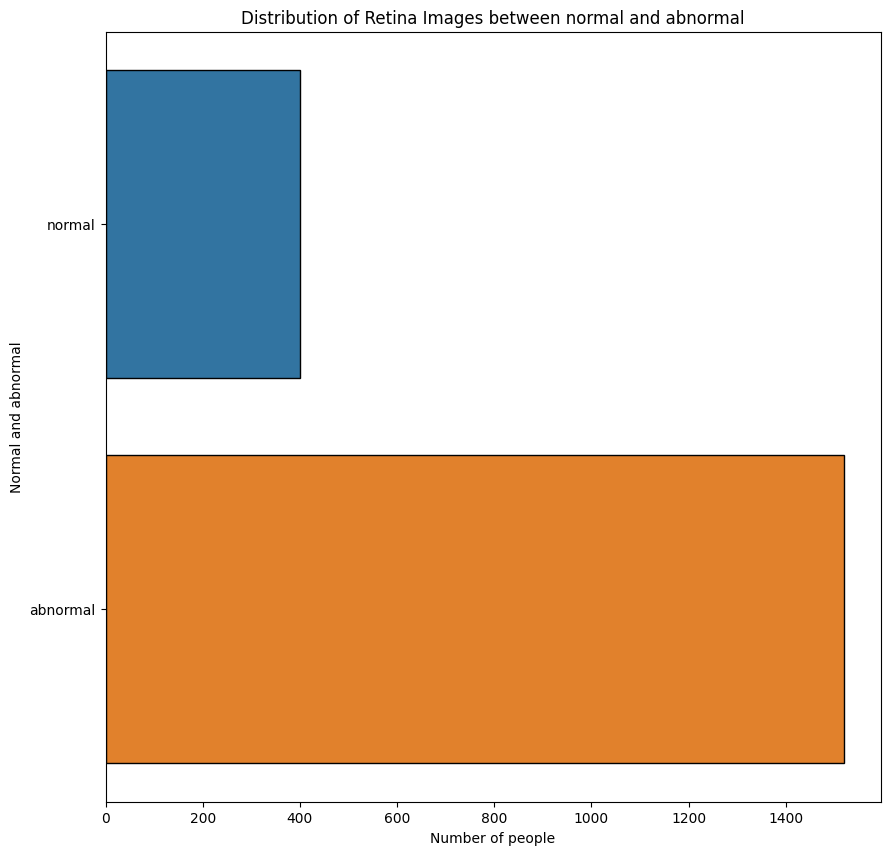

In [5]:
li = ['normal', 'abnormal']
normal = len(train_ds_csv[train_ds_csv['Disease_Risk']==0]['Disease_Risk'])
abnormal = len(train_ds_csv[train_ds_csv['Disease_Risk']==1]['Disease_Risk'])
person_freq = [normal, abnormal]
plt.figure(figsize = (10,10))
sns.barplot(y = li,
            x = person_freq,
            edgecolor = "black",
            orient = "h")
plt.title("Distribution of Retina Images between normal and abnormal")
plt.xlabel("Number of people")
plt.ylabel("Normal and abnormal")
plt.show()

In [6]:
!rm -r /kaggle/working/*

In [7]:
import os
directory_names = ['normal','abnormal']

base_path = 'dataset/'

# Create directories
for directory_name in directory_names:
    directory_path = os.path.join(base_path, directory_name)
    try:
        os.makedirs(directory_path)
    except FileExistsError:
        print(f"Directory '{directory_name}' already exists at '{directory_path}'")


In [8]:
def move(set_name):
    path='../input/retinal-disease-classification/'+set_name+'_Set/'+set_name+'_Set/'
    d_path=path+(set_name.split('_')[0] if set_name[0]!='E' else 'Validation')+'/'
    csv_path=path+'RFMiD_'
    if set_name[0]=='E':
        csv_path=csv_path+'Validation_Labels.csv'
    else:
        csv_path=csv_path+set_name+('ing' if set_name[1]=='e' else '')+'_Labels.csv'
    data=pd.read_csv(csv_path)
    for i in range(len(data.ID)):
        if data['Disease_Risk'][i] == 1:
            column_name = 'abnormal'
        else:
            column_name = 'normal'
            
        image_name=str(i+1)+'.png'
        source_path=d_path+image_name
        destination_path='dataset/'+column_name+'/'+image_name
        shutil.copyfile(source_path, destination_path)

In [9]:
move('Training')
print("Done Training")
move('Test')
print("Done Testing")
move('Evaluation')
print("Done Evaluation")

Done Training
Done Testing
Done Evaluation


# count each classes

In [10]:
root_directory = '/kaggle/working/dataset'

Folder: /kaggle/working/dataset/abnormal - Image count: 1601
Folder: /kaggle/working/dataset/normal - Image count: 585


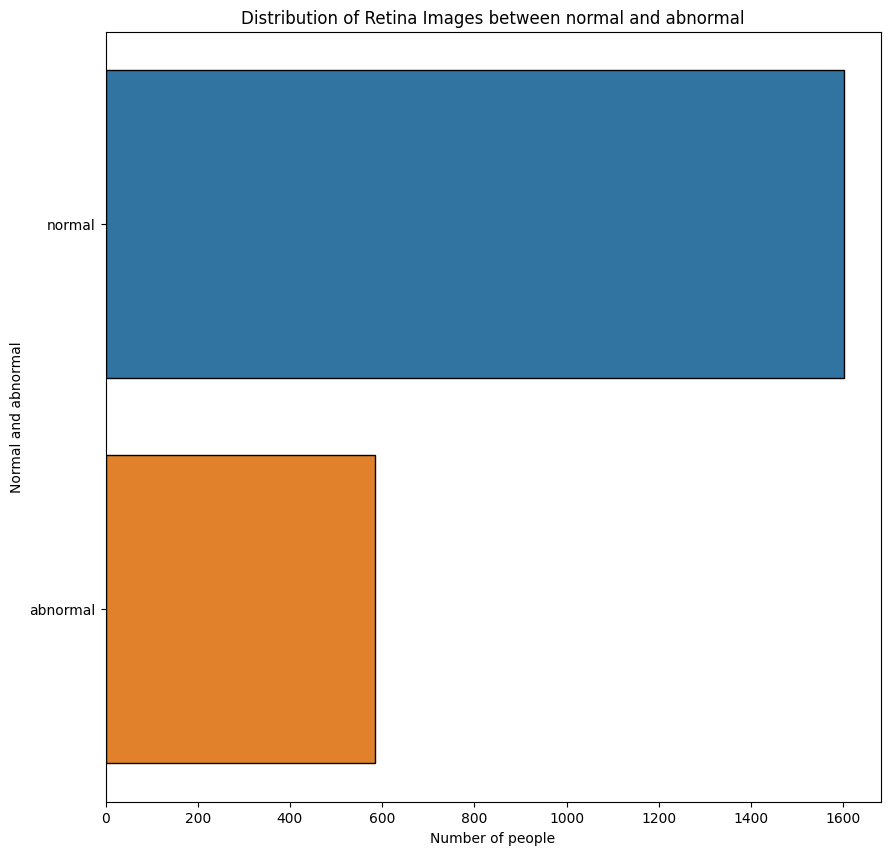

In [11]:
# Function to count images in a directory
def count_images(directory):
    image_count = len([file for file in os.listdir(directory) if file.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return image_count

# Function to delete folders with fewer than 30 images
def count_img_folders(path):
    a = []
    for root, dirs, files in os.walk(path):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            image_count = count_images(folder_path)
            a.append(image_count)
                                       
            print(f"Folder: {folder_path} - Image count: {image_count}")
    return a


li = ['normal', 'abnormal']
person_freq = count_img_folders('/kaggle/working/dataset')
plt.figure(figsize = (10,10))
sns.barplot(y = li,
            x = person_freq,
            edgecolor = "black",
            orient = "h")
plt.title("Distribution of Retina Images between normal and abnormal")
plt.xlabel("Number of people")
plt.ylabel("Normal and abnormal")
plt.show()

# Image Augmentation for Imbalanced eye Datasets

In [12]:
!rm -r /kaggle/working/augmented_dataset

rm: cannot remove '/kaggle/working/augmented_dataset': No such file or directory


In [13]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Set paths
input_folder = "/kaggle/working/dataset/normal"
output_folder = "/kaggle/working/augmented_dataset"

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Set the number of augmented images per original image
augmentation_factor = 6

# Initialize ImageDataGenerator with specified augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    height_shift_range=0.1,
    width_shift_range=0.1
)

# Get the list of image files in the input folder
image_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]
target_num_images = 1601- len(image_files)
if not os.path.exists("/kaggle/working/augmented_dataset/normal"):
    os.makedirs("/kaggle/working/augmented_dataset/normal")

# # Perform augmentation for each image
output_folder = "/kaggle/working/augmented_dataset/normal"
total_augmented_images = 0

for image_file in image_files:
    img_path = os.path.join(input_folder, image_file)
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    # Generate augmented images and save to the output folder
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=output_folder, save_prefix=image_file.split('.')[0], save_format='png'):
        i += 1
        total_augmented_images += 1
        if i >= augmentation_factor:
            break

        if total_augmented_images >= target_num_images:
            break

    if total_augmented_images >= target_num_images:
        break
    if total_augmented_images % 100 ==0:
        print('total_augmented_images : ',total_augmented_images)

print("Augmentation complete. Augmented images saved in:", output_folder)


total_augmented_images :  300
total_augmented_images :  600
total_augmented_images :  900
Augmentation complete. Augmented images saved in: /kaggle/working/augmented_dataset/normal


In [14]:
os.makedirs('/kaggle/working/balanced_dataset', exist_ok=True)
os.makedirs('/kaggle/working/balanced_dataset/abnormal', exist_ok=True)
os.makedirs('/kaggle/working/balanced_dataset/normal', exist_ok=True)

In [15]:
infolder = '/kaggle/working/dataset'
outfolder = '/kaggle/working/balanced_dataset'
abnormal_images = os.listdir(os.path.join(infolder, 'abnormal'))
for image in abnormal_images[:1601]:
    src_path = os.path.join(infolder, 'abnormal', image)
    dst_path = os.path.join(outfolder, 'abnormal', image)
    shutil.copy(src_path, dst_path)

In [16]:
normal_images = os.listdir(os.path.join(infolder, 'normal'))
for image in normal_images[:585]:
    src_path = os.path.join(infolder, 'normal', image)
    dst_path = os.path.join(outfolder, 'normal', image)
    shutil.copy(src_path, dst_path)
    

In [17]:
infolder_ad = '/kaggle/working/augmented_dataset'
normal_ad_images = os.listdir(os.path.join(infolder_ad, 'normal'))
for image in normal_ad_images[:1016]:
    src_path = os.path.join(infolder_ad, 'normal', image)
    dst_path = os.path.join(outfolder, 'normal', image)
    shutil.copy(src_path, dst_path)

# Deleting the extra images

In [18]:
# def delete_extra_images(root_folder):
#     subdir_images = {}
#     min_images = float('inf')  # Set initial minimum count to infinity

#     # Loop through the subdirectories to count the number of images in each
#     for subdir in os.listdir(root_folder):
#         subdir_path = os.path.join(root_folder, subdir)
#         if os.path.isdir(subdir_path):
#             subdir_images[subdir] = []
#             for file in os.listdir(subdir_path):
#                 if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
#                     subdir_images[subdir].append(file)
#             min_images = min(min_images, len(subdir_images[subdir]))

#     # Delete extra images in each subdirectory
#     for subdir, images in subdir_images.items():
#         extra_images = len(images) - min_images
#         if extra_images > 0:
#             print(f"Deleting {extra_images} images in {subdir}")
#             images_to_delete = random.sample(images, extra_images)  # Randomly select images for deletion
#             for image in images_to_delete:
#                 os.remove(os.path.join(root_folder, subdir, image))

In [19]:
# # Specify the root folder containing subdirectories with images

# delete_extra_images('/kaggle/working/balanced_dataset')

Folder: /kaggle/working/balanced_dataset/abnormal - Image count: 1601
Folder: /kaggle/working/balanced_dataset/normal - Image count: 1601


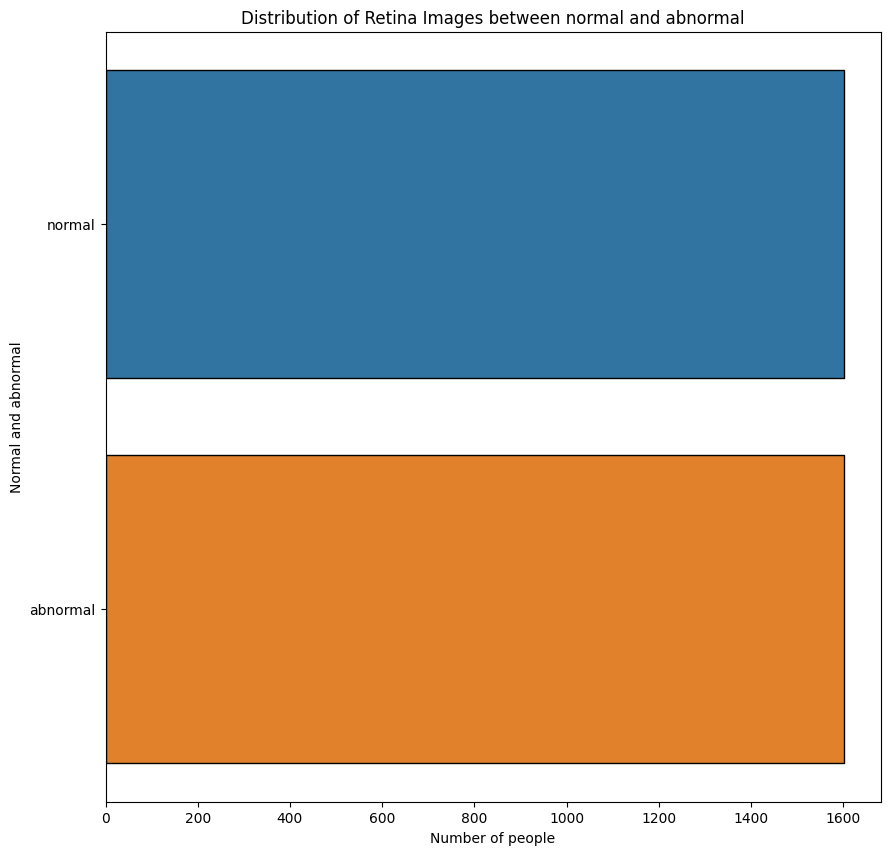

In [20]:
li = ['normal', 'abnormal']
person_freq = count_img_folders('/kaggle/working/balanced_dataset')
plt.figure(figsize = (10,10))
sns.barplot(y = li,
            x = person_freq,
            edgecolor = "black",
            orient = "h")
plt.title("Distribution of Retina Images between normal and abnormal")
plt.xlabel("Number of people")
plt.ylabel("Normal and abnormal")
plt.show()

# Pre-Processing the Data

In [21]:
BATCH_SIZE=64
IMAGE_SIZE=224
CHANNELS=3
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "balanced_dataset", shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3202 files belonging to 2 classes.


In [22]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle: ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds=ds.take(train_size)
    val_ds = ds.skip(train_size)

    return train_ds, val_ds

In [23]:
train_ds, val_ds = get_dataset_partitions_tf(dataset)

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255),
    layers.experimental.preprocessing.RandomContrast(factor=0.1),  # Adjust contrast
    layers.experimental.preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1),  # Random zoom
])

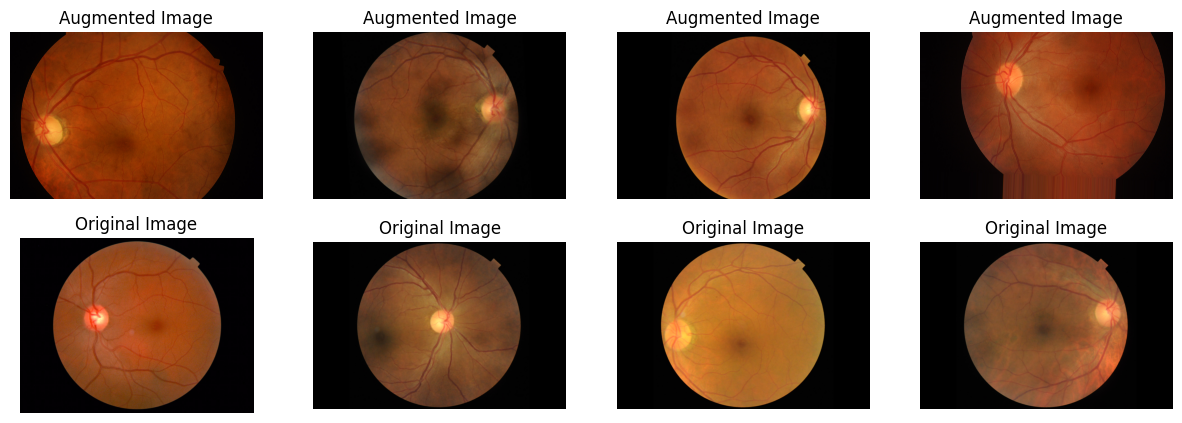

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob

# Define the paths for the image lists
image_list_paths = glob('/kaggle/working/augmented_dataset/normal/*.png')
image_no_paths = glob('/kaggle/working/dataset/normal/*.png')

# Take the first 5 images from each list
selected_image_list_paths = image_list_paths[:4]
selected_image_no_paths = image_no_paths[:4]

# Display the selected images
plt.figure(figsize=(15, 5))

# Display images from image_list
for i, image_path in enumerate(selected_image_list_paths):
    plt.subplot(2, 4, i + 1)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Augmented Image')

# Display images from image_no
for i, image_path in enumerate(selected_image_no_paths):
    plt.subplot(2, 4, i + 5)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original Image')

plt.show()


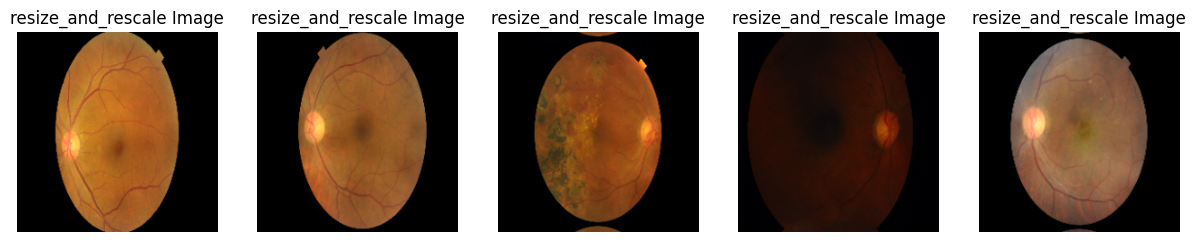

In [26]:
sample_images = next(iter(train_ds.take(5)))
rescaled_images = resize_and_rescale(sample_images[0], training=True)  # Ensure training=True for data augmentation

# Display the images
plt.figure(figsize=(15, 15))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(rescaled_images[i].numpy())
    plt.title('resize_and_rescale Image')
    plt.axis("off")

plt.show()

In [27]:
dataset.class_names

['abnormal', 'normal']

# CNN Model

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(os.listdir(root_directory))
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(256, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(512, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(512, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(512, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 222, 222, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (64, 111, 111, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 109, 109, 256)       590080    
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 54, 54, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (64, 52, 52, 512)        

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
EPOCHS=60
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1,
    validation_data=val_ds
)

Epoch 1/60
40/40 [==============================] - 197s 5s/step - loss: 0.7558 - accuracy: 0.5400 - val_loss: 0.8016 - val_accuracy: 0.5270
Epoch 2/60
40/40 [==============================] - 14s 363ms/step - loss: 0.7275 - accuracy: 0.6137 - val_loss: 0.6125 - val_accuracy: 0.6776
Epoch 3/60
40/40 [==============================] - 14s 362ms/step - loss: 0.5962 - accuracy: 0.7178 - val_loss: 0.5771 - val_accuracy: 0.6662
Epoch 4/60
40/40 [==============================] - 14s 362ms/step - loss: 0.9723 - accuracy: 0.7270 - val_loss: 0.5264 - val_accuracy: 0.7784
Epoch 5/60
40/40 [==============================] - 14s 362ms/step - loss: 4.2239 - accuracy: 0.7614 - val_loss: 0.4659 - val_accuracy: 0.7841
Epoch 6/60
40/40 [==============================] - 14s 361ms/step - loss: 0.8650 - accuracy: 0.7230 - val_loss: 0.4751 - val_accuracy: 0.8011
Epoch 7/60
40/40 [==============================] - 14s 362ms/step - loss: 3.8512 - accuracy: 0.7582 - val_loss: 0.4318 - val_accuracy: 0.8224
E

# Graphs and Model Evaluation

Text(0.5, 1.0, 'Training and Validation loss')

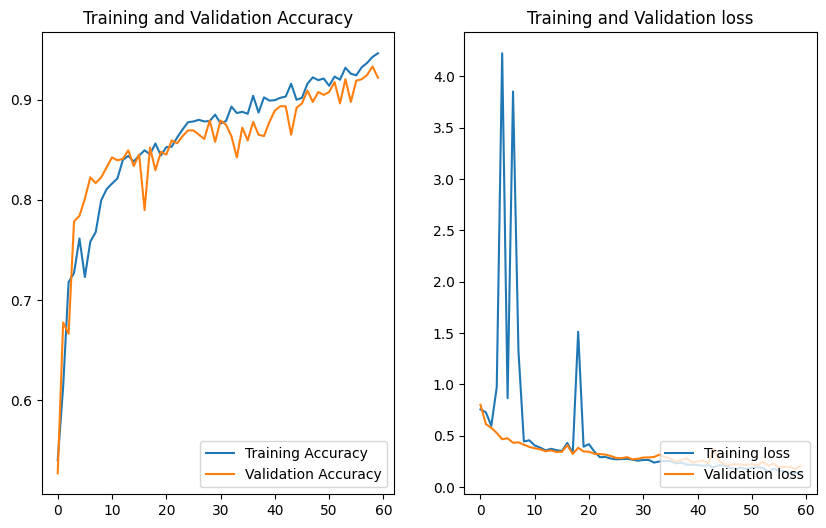

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

axis_size=len(acc)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(range(axis_size), acc, label='Training Accuracy')
plt.plot(range(axis_size), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(range(axis_size), loss, label='Training loss')
plt.plot(range(axis_size), val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation loss')

In [31]:
# Evaluate the model
scores = model.evaluate(val_ds)
print(f'Test accuracy: {scores}')

11/11 [==============================] - 1s 108ms/step - loss: 0.2069 - accuracy: 0.9219
Test accuracy: [0.20692071318626404, 0.921875]


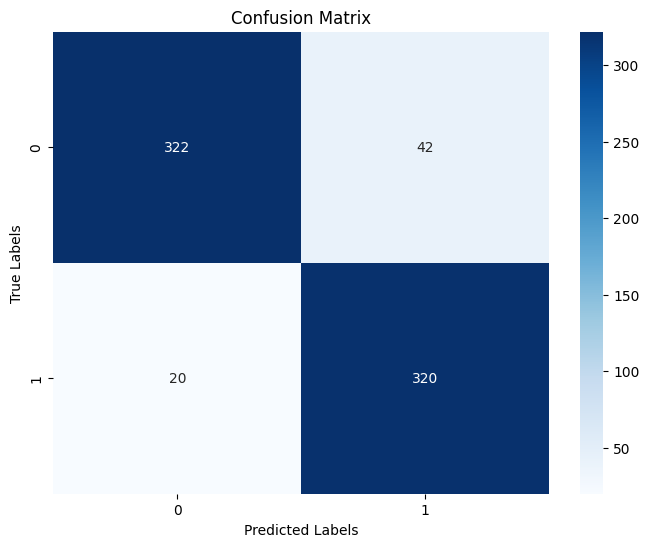

In [32]:
predicted_labels = []
true_labels = []

for images, labels in val_ds:
    predictions = model(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Obtaining the class with maximum probability as the predicted label
    true_labels.extend(labels)

predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()